In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from lmfit import Model
from scipy.stats import linregress
from scipy import integrate

from scipy.signal import savgol_filter

In [73]:
# Variables

cv = pd.DataFrame()
l = pd.DataFrame()
d = pd.DataFrame()
cap = pd.DataFrame()
eff = pd.DataFrame()
eis_df = pd.DataFrame()
pitt_df = pd.DataFrame()

final_results = {}

F = 96485 # C/mol
# col_dep = ['Time (s)', 'Potential vs Ag/AgCl (V)', 'Current (A)', 'Charge (C)']
col_cv = ['Potential vs Li$^+$/Li (V)', 'Current (A)', 'Charge (C)', 'Time (s)', 'Scan']
col = ['Time', 'Time (s)', 'Current (μA)', 'Potential vs Li$^+$/Li (V)'] # 'Current Density (µA/cm$^2$)'
col2 = [col[3], 'D (cm$^2$/s)', '$\Delta$Q', 'Cs - Co (mol/cm$^3$)']
col_iv = ['Potential applied (V)', 'Current (A)', 'Time (s)']

potentials = ['{:.2f}'.format(round(i, 4))  for i in np.arange(3.90, 4.20, 0.05)]

formatter_1e3 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e3))
formatter_1e6 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))
formatter_1e4 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))

palette = 'cividis'


In [74]:
# Set up files for procedure 'LMO_CV_Galvcycl_EIS.nox' on Week 6 2024
# Adapted from L23

def setup_files(path):

    files = [os.path.join(path, i) for i in os.listdir(path)]
    folders = ['CV', 'lith', 'delith', 'EIS']
    
    for i in folders:
        if not os.path.exists(os.path.join(path, i)):
            os.mkdir(os.path.join(path, i))
        
    for i in os.listdir(path):
        if 'EIS_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'EIS', i))

    for i in os.listdir(path):
        if '_lith_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'lith', i))
        elif '_delith' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'delith', i))
        elif i != 'README.txt' and len(i) > 7:
            os.rename(os.path.join(path, i), os.path.join(path, 'CV', i))
    
    for file_path in [os.path.join(path, 'lith', i) for i in os.listdir(os.path.join(path, 'lith')) if i != 'README.txt']:
        directory, filename = os.path.split(file_path)
        if len(filename) < 3:
            continue
        #Adding folder for cycles -> last number of filename
        if not os.path.exists(os.path.join(path, 'lith', filename[-5:-4])):
            os.mkdir(os.path.join(path, 'lith', filename[-5:-4]))
            
        numeric_part = filename.split('_')[-1].split('.txt')[0].split('C')[1]
        if len(numeric_part) == 2:
            number_wzero = '0' + numeric_part
        else:
            number_wzero = numeric_part
        
        new_filename =filename[:-7] + filename[-7:-4].replace(numeric_part, number_wzero) + '.txt'  # filename.replace(numeric_part, numeric_two_decimals)
        new_file_path = os.path.join(directory, filename[-5:-4], new_filename)
    
        if file_path != new_file_path:  
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
        
    for file_path in [os.path.join(path, 'delith', i) for i in os.listdir(os.path.join(path, 'delith')) if i != 'README.txt']:
        directory, filename = os.path.split(file_path)
        if len(filename) < 3:
            continue
        #Adding folder for cycles -> last number of filename
        if not os.path.exists(os.path.join(path, 'delith', filename[-5:-4])):
            os.mkdir(os.path.join(path, 'delith', filename[-5:-4]))
        
        numeric_part = filename.split('_')[-1].split('.txt')[0].split('C')[1]
        if len(numeric_part) == 2:
            number_wzero = '0' + numeric_part
        else:
            number_wzero = numeric_part
            
        new_filename =filename[:-7] + filename[-7:-4].replace(numeric_part, number_wzero) + '.txt'  # filename.replace(numeric_part, numeric_two_decimals)
        new_file_path = os.path.join(directory, filename[-5:-4], new_filename)
        if file_path != new_file_path:  
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
        

            
    
    for file_path in [os.path.join(os.path.join(path, 'EIS'), i) for i in os.listdir(os.path.join(path, 'EIS'))]:
        directory, filename = os.path.split(file_path)
        if len(filename) < 3:
            continue
        #Adding folder for cycles -> last number of filename
        if not os.path.exists(os.path.join(path, 'EIS', filename[-5:-4])):
            os.mkdir(os.path.join(path, 'EIS', filename[-5:-4]))
    
            
        numeric_part = filename.split('_')[1]
        numeric_with_two_decimals = '{:.2f}'.format(float(numeric_part))
        new_filename = filename.replace(numeric_part, numeric_with_two_decimals)
        new_file_path = os.path.join(directory, filename[-5:-4], new_filename)
        if file_path != new_file_path:        
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
           
# Methods
       
def cc(path, area, thickness, sample):
    
    cv_path = os.path.join(path, 'CV')
    lith_path = os.path.join(path, 'lith')
    delith_path = os.path.join(path, 'delith')
    cv_df = pd.DataFrame()
    
    ### CV
    for i in sorted(os.listdir(cv_path), reverse=True): # sorted to get initial first
        f = os.path.join(cv_path, i)
        df = pd.read_csv(f, sep = ';', skiprows = 1, names = col_cv)
        df['Current density (A/cm$^2$)'] = df[col_cv[1]] / area
        if '_Initial_' in i:
            df['CV'] = 'Initial'
        else:
            df['CV'] = 'Final'
        df['Sample'] = sample
        cv_df = pd.concat([cv_df, df], ignore_index=True)
    
    lithiation = pd.DataFrame()
    delithiation = pd.DataFrame()
    capacity_l = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    capacity_d = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    efficiency = pd.DataFrame()
    cycles_path_l = [os.path.join(lith_path, i) for i in os.listdir(lith_path)]
    set = 1
    cyc = 1
    for cycle in cycles_path_l:
        files = [os.path.join(cycle, i) for i in os.listdir(cycle)]
        for file in files:
            df = pd.read_csv(file, sep = ';')
            df['Set'] = set
            df['Cycle'] = cyc
            df['Capacity (mAh/cm$^3$)'] = -df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
            df['Sample'] = sample
            df['Process'] = 'Lithiation'
            
            # x = df['Capacity (mAh/cm$^3$)']
            x = df['WE(1).Charge (C)']
            y = df['WE(1).Potential (V)']
            y_smooth = savgol_filter(y, 11, 1)
            df['dQ/dV'] = np.gradient(y_smooth, x)
            
            lithiation = pd.concat([lithiation, df], ignore_index=True)
            cyc += 1
        set += 1
        cyc = 1

    cycles_path_d = [os.path.join(delith_path, i) for i in os.listdir(delith_path)]
    set = 1
    cyc = 1
    for cycle in cycles_path_d:
        files = [os.path.join(cycle, i) for i in os.listdir(cycle)]
        for file in files:
            df = pd.read_csv(file, sep = ';')
            df['Set'] = set
            df['Cycle'] = cyc
            df['Capacity (mAh/cm$^3$)'] = df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
            df['Sample'] = sample
            df['Process'] = 'Delithiation'
            
            # x = df['Capacity (mAh/cm$^3$)']
            x = df['WE(1).Charge (C)']
            y = df['WE(1).Potential (V)']
            y_smooth = savgol_filter(y, 11, 1)
            df['dQ/dV'] = np.gradient(y_smooth, x)
            
            delithiation = pd.concat([delithiation, df], ignore_index=True)
            cyc += 1
        set += 1
        cyc = 1  
    
    results = [cv_df, lithiation, delithiation]
    return results
    # display(delithiation)
    # n = 1
    # for i in l:
    #     df = pd.read_csv(i, sep = ';')
    #     df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
    #     df['Cycle'] =  str(n) ### string or int
    #     df['Capacity_calc'] = -df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
    #     lithiation = pd.concat([lithiation, df], ignore_index=True)
    #     capacity_l.loc[n] = (max(df['Capacity_calc']), n, 'Lithiation')
    #     n += 1

def cv_plot(df, color_map, dpi):
    fig, ax = plt.subplots(dpi = dpi)
    sns.scatterplot(data = df, x = col_cv[0], y = 'Current density (A/cm$^2$)', edgecolor = None, s = 5 )
    ax.yaxis.set_major_formatter(formatter_1e6)
    plt.ylabel('Current density (µA/cm$^2$)')

def cc_plot(df, color_map, dpi):
    number_of_cycles = df[1]['Cycle'].nunique()
    # number_of_cycles = df[1]['Set'].nunique()
    palette = sns.color_palette(color_map, n_colors = number_of_cycles) # + 2)
    fig, ax = plt.subplots(dpi = dpi)
    sns.lineplot(data = df[1], x = 'Capacity (mAh/cm$^3$)', y = 'WE(1).Potential (V)', hue = 'Cycle', style = 'Set', palette=palette,  legend = False)#, edgecolor = None)
    sns.lineplot(data = df[2], x = 'Capacity (mAh/cm$^3$)', y = 'WE(1).Potential (V)', hue = 'Cycle', style = 'Set', palette=palette, legend = False)#, edgecolor = None)
    
    # sns.lineplot(data = df[1], x = 'Capacity (mAh/cm$^3$)', y = 'WE(1).Potential (V)', hue = 'Set', style =  'Cycle', palette=palette, legend = False) #, edgecolor = None)
    # sns.lineplot(data = df[2], x = 'Capacity (mAh/cm$^3$)', y = 'WE(1).Potential (V)', hue = 'Set', style =  'Cycle', palette=palette, legend = False) #, edgecolor = None)
    
    # plt.grid()
    plt.ylabel(col_cv[0])

    cmap = plt.get_cmap(color_map)
    norm = Normalize(vmin = df[1]['Cycle'].min(), vmax = df[1]['Cycle'].max())
    # norm = Normalize(vmin = df[1]['Set'].min(), vmax = df[1]['Set'].max())
    
    num_cycles = df[1]['Cycle'].max()
    # num_cycles = df[1]['Set'].max()
    sm = ScalarMappable(cmap=cmap, norm = norm)
    sm.set_array([])  # An empty array is required for the ScalarMappable
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
    cbar.set_label('Cycles') 
    # cbar.set_label('Set')

def dq_dv_plot(df_list, color_map, dpi):
    
    palette = sns.color_palette(color_map)
    l = df_list[1]
    d = df_list[2]
    df = pd.concat([l, d], ignore_index = True)
    fig, ax = plt.subplots(dpi = dpi)
    # sns.scatterplot(data = l, x = 'WE(1).Potential (V)', y = 'dQ/dV', hue = 'Process', edgecolor = None, s = 1)
    # sns.scatterplot(data = d, x = 'WE(1).Potential (V)', y = 'dQ/dV', hue = 'Process', edgecolor = None, s = 1)
    sns.scatterplot(data = df, x = 'WE(1).Potential (V)', y = 'dQ/dV', hue = 'Process', edgecolor = None, s = 1)
    ax.set_xlabel(col_cv[0])
    ax.grid()

In [75]:
#STD_02 Second sample for Xinhua after breaking 1st at 5V
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\24LSB01\STD_02'
setup_files(path)
area = np.pi
thickness = 90
sample = 'STD_02'
results = cc(path, area, thickness, sample)

In [76]:
### PLOT STD_02
color_map = "Oranges"
# cv_plot(results[0], color_map, 100)
# cc_plot(results, color_map, 100)

In [77]:
# STD_02_2 New sample after blowing up to 5V
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\24LSB01\STD_02_2'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO 1C'
std02_1C = cc(path, area, thickness, sample)

In [78]:
###PLOT STD_02_2
# cv_plot(std02_2[0], color_map, 100)
# cc_plot(std02_1C, color_map, 100)
# dq_dv_plot(std02_1C, color_map, 100)
# plt.ylim(-100, 400)

In [79]:
#Pt10nm LMO

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\Pt10nm_LMO90nm\Pt10_01'
setup_files(path)
area = np.pi * 0.5 **2
thickness = 90
sample = 'Pt10nm LMO 1C'
pt10nm = cc(path, area, thickness, sample)


In [80]:
#### PLOT Pt10nm LMO
# cv_plot(pt10nm[0], color_map, 200)
# cc_plot(pt10nm, color_map, 100)
# dq_dv_plot(pt10nm, color_map, 100)
# plt.ylim(0, 400)

In [81]:
# STD_02_2C
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\24LSB01\STD02_2C'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO 2C'
std02_2c = cc(path, area, thickness, sample)

In [82]:
# cv_plot(std02_2c[0], color_map, 100)
# cc_plot(std02_2c, color_map, 100)
# dq_dv_plot(std02_2c, color_map, 100)
# plt.ylim(-10, 250)

In [87]:
# STD_02_5C
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\24LSB01\STD_02_5C'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO 5C'
std02_5c = cc(path, area, thickness, sample)

(-10.0, 100.0)

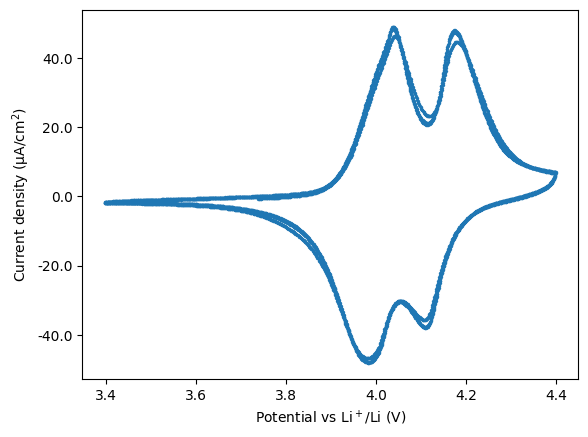

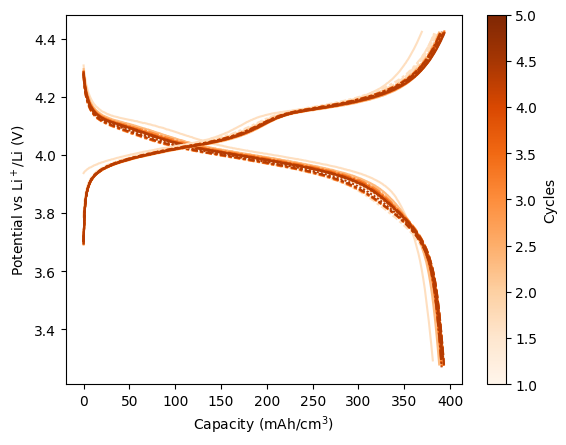

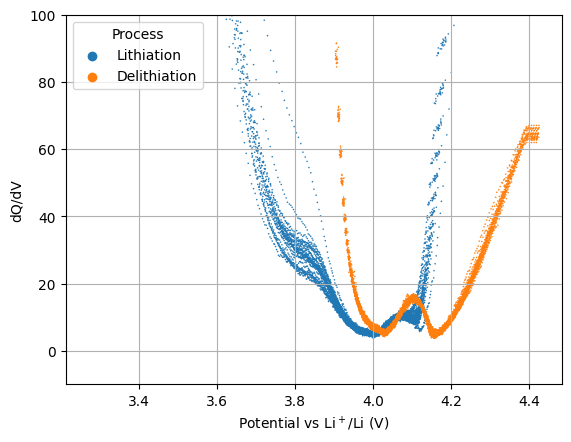

In [89]:
#### STD_02_5C Plot
cv_plot(std02_5c[0], color_map, 100)
cc_plot(std02_5c, color_map, 100)
dq_dv_plot(std02_5c, color_map, 100)
plt.ylim(-10, 100)

In [ ]:
# Derivative dQ/dV

ca = 450
cb = 820
# x = std02_5c[1]['Capacity (mAh/cm$^3$)'][ca:cb]
x = -std02_5c[1]['WE(1).Charge (C)'][ca:cb]
y = std02_5c[1]['WE(1).Potential (V)'][ca:cb]

# Smooth the data using a Savitzky-Golay filter
window_size = 11  # Adjust the window size as needed
order = 1  # Adjust the polynomial order as needed
y_smooth = savgol_filter(y, window_size, order)
x_smooth = savgol_filter(x, window_size, order)

dy_dx = np.gradient(y, x)
dy_dx_smooth = np.gradient(y_smooth, x)
dy_dx_xsmooth = np.gradient(y, x_smooth)

fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.lineplot(x = x, y = y, ax = ax[0], label = 'Data')
sns.lineplot(x = x, y = y_smooth, ax = ax[0], label = 'SavGol')
ax[0].set_ylabel(col_cv[0])
plt.plot(y, dy_dx_smooth)
plt.plot(y, dy_dx_xsmooth)
plt.ylabel('dQ/dV')
plt.xlabel(col_cv[0])


In [ ]:
# Compile 1C, 2C and 5C
results = [std02_1C, std02_2c, std02_5c]
results_df = pd.DataFrame()
for i in results:
    results_df = pd.concat([results_df, i[1]], ignore_index = True)
fig, ax = plt.subplots(dpi = 100)

sns.scatterplot(data = results_df, x = 'Capacity (mAh/cm$^3$)', y = 'WE(1).Potential (V)', hue = 'Sample', edgecolor = None, s = 2)

#Remove data below 3.4 V


In [ ]:
# Capacity from CV

def capacity_cv(df, area, thickness, time_cut_off_beg, time_cut_off_end):
    x = df[col_cv[3]][time_cut_off_beg:time_cut_off_end]
    y = df[col_cv[1]][time_cut_off_beg:time_cut_off_end] / area # Current Density
    area_under_curve = np.trapz(y, x)
    capacity = area_under_curve /3.6 / (1e-7 * thickness) # removed area since we have current density
    if capacity < 0:
        capacity = -capacity
    text  = f'{round(capacity)} mAh/cm$^3$'
    sns.lineplot(x = x, y = y)
    ax.axhline(y = 0, color = 'gray', linestyle = '--')
    plt.fill_between(x, y, alpha=0.1)#, color = 'tab:blue')
    plt.text(x.median(), y.mean(), text)

# df_a = results[0]
# fig, ax = plt.subplots(dpi = 200)
# plt.xlim(0, 5000)
# ax.yaxis.set_major_formatter(formatter_1e6)
# ax.set_ylabel('Current Density (µA/cm$^2$)')

# capacity_cv(df_a, area, thickness, 0, 1000)
# capacity_cv(df_a, area, thickness, 1000, 2000)
# capacity_cv(df_a, area, thickness, 2000, 2900)
# capacity_cv(df_a, area, thickness, 2900, 4000)

In [ ]:


# fig, ax = plt.subplots(dpi = 100)
# sns.lineplot(x = df['Corrected Time (s)'], y = df['WE(1).Current (A)'])
# ax.axhline(y = 0, color = 'gray', linestyle = '--', alpha = 0.4)

# plt.xlim(0, 5200)

# fig, ax = plt.subplots(dpi = 100)
# ci = 0
# cf = 6500
# sns.scatterplot(x = df['WE(1).Potential (V)'][ci:cf], y = df[col_cv[1]][ci:cf], edgecolor = None, s = 3)
# ax.axhline(y = 0, color = 'gray', linestyle = '--', alpha = 0.4)

In [ ]:
# # STD
# path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\24LSB01\STD'
# setup_files(path)
# area = np.pi
# thickness = 90
# sample = 'STD'
# # results_std = cc(path, area, thickness, sample)
# # cv_plot(results_std[0], color_map, 100)
# # cc_plot(results_std, 'BuPu', 100)


In [ ]:
# path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\24LSB01\STD_02_2\EIS\1'
# fit_file = [os.path.join(path, i) for i in os.listdir(path) if 'Fit' in i]
# df = pd.read_csv(fit_file[0], sep = '\t', skiprows=2)
# sns.scatterplot(data = df, x = 'FreeVariable', y = 'Warburg Coeff. 1: value' )